<a href="https://colab.research.google.com/github/silverstar0727/1day-1commit-challenge/blob/master/machine_learning_ch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습(ensemble learning)
1. Voting (분류기끼리의 앙상블)
2. Bagging (sample끼리의 앙상블 + voting)
3. Boosting (weight끼리의 앙상블)
4. Stacking (meta model)



In [24]:
# 앙상블과 개별분류기의 에러확인
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier / 2.))
  probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
  for k in range(k_start, n_classifier + 1)]
  
  return sum(probs)

ensemble_error(n_classifier = 11, error = 0.25)

0.03432750701904297

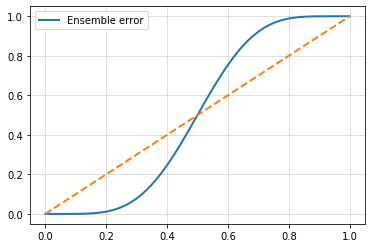

In [25]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [(ensemble_error(n_classifier = 11, error = error)) for error in error_range]

plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', linewidth = 2)
plt.legend(loc = 'upper left')
plt.grid(alpha = 0.5)
plt.show()

### 다수결 투표를 이용한 분류 앙상블

numpy의 average와 argmax를 이용한 가중치가 적용된 다수결투표 구현

In [26]:
import numpy as np
np.argmax(np.bincount([0,0,1], weights = [0.2, 0.2, 0.6]))

1

In [27]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [28]:
np.argmax(p)

0

In [0]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self,classifiers, vote = 'classlabel', weights = None):
    self.classifiers = classifiers
    self.vote = vote
    self.weights = weights
    self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}

  def fit(self,X,y):
    self.lablenc_ = LabelEncoder()
    self.lablenc_.fit(y)
    self.classes_ = self.lablenc_.classes_
    self.classifiers_ = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X), axis = 1)

    else:
      predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
      maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights = self.weights)),
                                     axis = 1, arr = predictions)

    maj_vote = self.lablenc_.inverse_transform(maj_vote)
    return maj_vote

  def predict_proba(self,X):
    probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
    avg_proba = np.average(probas, axis = 0, weights = self.weights)

    return avg_proba

  def get_params(self, deep = True):
    if not deep: 
      return super(MajorityVoteClassifier, self).get_params(deep = False)

    else:
      out = self._name_estimators.copy()
      for name, step in six.iteritems(self.named_classifiers_):
        for key, value in six.iteritems(step.get_params(deep = True)):
          out['%s__%s' & (name, key)] = value

    return out

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

In [37]:
# 10겹 교차검증
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 0.001, random_state = 1)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision tree', 'KNN']
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, scoring = 'roc_auc')

  print(scores.mean(), scores.std(), label)

0.9166666666666666 0.1536590742882148 Logistic Regression
0.8666666666666668 0.18333333333333332 Decision tree
0.85 0.13333333333333333 KNN


#### 다수결을 통한 ensmble


In [38]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels +=['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, scoring = 'roc_auc')
  print(scores.mean(), scores.std(), label)

0.9166666666666666 0.1536590742882148 Logistic Regression
0.8666666666666668 0.18333333333333332 Decision tree
0.85 0.13333333333333333 KNN
0.9833333333333334 0.04999999999999999 Majority voting
